# LALSimulation
This uses LALSimulation. The reason this has been put on pause as ```XLAL Error - XLALSimIMRSpinAlignedEOBModes: Ringdown frequency > Nyquist frequency!``` is an error that keeps popping up because I'm struggling to actually change the parameter_check() values.

We're using OOP to create a LALCompactBinaryCoalescenseGenerator object: https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/classlalsimulation_1_1gwsignal_1_1core_1_1waveform_1_1_l_a_l_compact_binary_coalescence_generator.html

In [138]:
%matplotlib inline

import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wv
from astropy import units as u
import matplotlib.pyplot as plt
waveform.parameter_check()

{'mass1': <Quantity 1. solMass>,
 'mass2': <Quantity 1. solMass>,
 'spin1x': <Quantity 0.>,
 'spin1y': <Quantity 0.>,
 'spin1z': <Quantity 0.>,
 'spin2x': <Quantity 0.>,
 'spin2y': <Quantity 0.>,
 'spin2z': <Quantity 0.>,
 'deltaT': <Quantity 0.015625 s>,
 'f22_start': <Quantity 20. Hz>,
 'f22_ref': <Quantity 20. Hz>,
 'phi_ref': <Quantity 0. rad>,
 'distance': <Quantity 1. Mpc>,
 'inclination': <Quantity 0. rad>,
 'eccentricity': <Quantity 0.>,
 'longAscNodes': <Quantity 0. rad>,
 'meanPerAno': <Quantity 0. rad>,
 'deltaF': <Quantity 0.0625 Hz>,
 'f_max': <Quantity 32. Hz>}

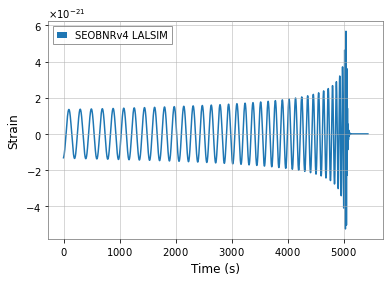

/home/cschun/.local/lib/python3.9/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


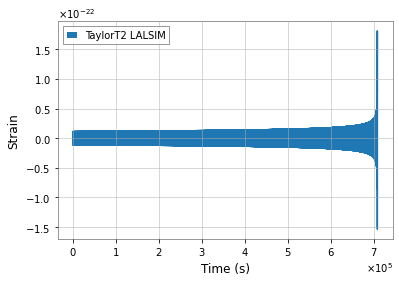

In [140]:
labels = ['SEOBNRv4', 'TaylorT2', 'SEOBNRv4_ROM_NRTidalv2_NSBH']
m1 = [30, 1.2, 19.5] #varying masses based on aprox we're using. for i = 3, m1 >= m2
m2 = [20, 1.5, 1.5]

# we need to figure out all these values
dt = 1./4096
df = 1./4
dist = 100
fmin = 30
fref = 4096
fmax = 4096

lalsim_data = []
if __name__=='__main__':
    approxs = [lalsimulation.SEOBNRv4, lalsimulation.TaylorT2, lalsimulation.SEOBNRv4_ROM_NRTidalv2_NSBH]
    parentWV = wv.CompactBinaryCoalescenceGenerator()
    
    for i in range(2):
        waveform = wv.LALCompactBinaryCoalescenceGenerator(approxs[i])
        lalsim_data.append(waveform.generate_td_waveform(mass1 = m1[i]*u.solMass,
                                                         mass2 = m2[i]*u.solMass,
                                                         deltaT = dt*u.s, 
                                                         deltaF = df*u.Hz,
                                                         distance = dist*u.Mpc,
                                                         f_max = fmax*u.Hz))

        plt.plot(range(len(lalsim_data[i][i])), lalsim_data[i][0], label=labels[i]+" LALSIM") #solve the time issue

        plt.ylabel('Strain')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

# PyCBC
For this I tried using PyCBC, with https://pycbc.org/pycbc/latest/html/waveform.html as a reference point.

The most common error I'm receiving is ```XLAL Error - SEOBNRv4ROMCore (LALSimIMRSEOBNRv4ROM.c:772): Error setting up SEOBNRv4ROM data - check your $LAL_DATA_PATH```. Which I'm receiving as an error for LALSimulation as well when I attempt to use SEOBNRv4_ROM_NRTidalv2_NSBH. Besides this, PyCBC seems to be working far better than LALSimulation, and it's also built on using LALSimulation.

This is also very loud at 0? Which I don't like the look of.

In [34]:
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform

In [132]:
for i in range(2):
    hp, hc = get_td_waveform(approximant=aproxs[i], mass1=m1[i], mass2=m2[i], delta_t=dt,
                             delta_f=df, distance=dist, f_final = fmax)
    plt.plot(hp.sample_times, hp, label=aproxs[i])

    plt.ylabel('Strain')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.show()

NameError: name 'fmax' is not defined

# Data Whitening

In [77]:
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import numpy as np

In [57]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

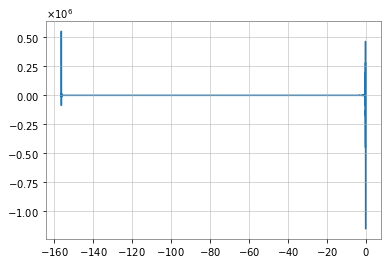

In [123]:
hp, hc = get_td_waveform(approximant=aproxs[1], mass1=m1[1], mass2=m2[1], delta_t=1.0/4096,
                         f_lower=20, distance=100, f_ref=20, delta_f=1./4, f_final = 2048)
def preprocessing(data):
    fs = 4096
    NFFT = 1*fs

    pxx, freq = mlab.psd(data, Fs = fs, NFFT = NFFT) #obtains transformed signal via welch's psd
    psd = interp1d(freq, pxx) # constructs the interpolated function
    time = hp.sample_times # times between values
    dt = time[1]-time[0] # time binning
    whitened_SEOBNRv4 = whiten(data, psd, dt)

    bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    strain_SEOBNRv4 = filtfilt(bb, ab, whitened_SEOBNRv4)
    strain_L1_shift = -np.roll(strain_SEOBNRv4,int(3.9*fs))
    plt.plot(time, strain_SEOBNRv4, label=aproxs[i])
    plt.show()

preprocessing(hp)

In [101]:
len(lalsim_data[1][0])

463668

# Other Resources
- https://github.com/Chaitany1729/nn_for_gw
- https://github.com/eric-moreno/Anomaly-Detection-Autoencoder
- https://github.com/timothygebhard/ggwd/

In [244]:
def generate_waveform(phiref, deltaT, m1, m2, fmin, dist, incl):
    approx = lalsimulation.SEOBNRv4  # Taylor T2 approximant
    fref = fmin
 
    hp, hc = lalsimulation.SimInspiralChooseTDWaveform(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., dist*1e6*lal.PC_SI, incl,
        phiref, 0., 0., 0., deltaT, fmin, fref, None, approx)

    # return the frequency domain plus and cross waveforms
    return hp.data.data, hc.data.data

fmin = 20
df = 0.1

m1 = 30
m2 = 30

phiref = 0
iota = 0
dist = 100. # distance in Mpc
deltaT = 1./4096

hp, hc = generate_waveform(phiref, deltaT, m1, m2, fmin, dist, iota)